In [117]:
import os
import time
import numpy as np
import numpy.random as npr
import re
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from tqdm import tqdm
from scipy.special import digamma, loggamma

assert os.path.exists("/Users/daany/Downloads/HT/LDA/ap.txt") and os.path.exists("/Users/daany/Downloads/HT/LDA/vocab.txt")

with open("vocab.txt", "r") as f:
    vocab = set(f.read().splitlines())

with open("ap.txt", "r") as f:
    raw_text = f.read()

texts = re.findall(r"<TEXT>(.*?)</TEXT>", raw_text, re.DOTALL)
stop_words = set(stopwords.words("english"))
documents = []

for text in texts:
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words and word in vocab]
    documents.append(tokens)

N = len(documents)
V = len(vocab)

doc_term_matrix = np.zeros((N, V))
vocab_to_index = {word: i for i, word in enumerate(vocab)}

for doc_idx, tokens in enumerate(documents):
    token_counts = Counter(tokens)
    for token, count in token_counts.items():
        if token in vocab_to_index:
            term_idx = vocab_to_index[token]
            doc_term_matrix[doc_idx, term_idx] = count

nonzero_idxs = []
for doc in doc_term_matrix:
    nonzero_idx = np.where(doc > 0)[0]
    nonzero_idxs.append(sorted(nonzero_idx))

ETA = 1 / V
ALPHA = 0.5
K = 30 

def init_variational_params(doc_term_matrix, K, rand_state=0):
    N, V = doc_term_matrix.shape # N is number of documents
    # rs = npr.RandomState(rand_state)
    # LAMBDA = rs.random(size=(K, V)) + 0.001
    LAMBDA = np.random.uniform(low=0.01, high=1.00, size=(K, V))
    GAMMA = np.ones((N, K))
    PHI = []
    for doc in doc_term_matrix:
        num_words_per_doc = np.sum((doc > 0).astype("int32"))
        doc_PHI = np.ones((num_words_per_doc, K))
        doc_PHI = doc_PHI / K
        PHI.append(doc_PHI)

    return LAMBDA, GAMMA, PHI

def compute_ELBO(LAMBDA, GAMMA, PHI, doc_term_matrix, nonzero_idxs, K):
    N, V = doc_term_matrix.shape
    ELBO = 0

    E_log_p_BETA = 0
    for k in range(K):
        E_log_p_BETA += (ETA - 1) * np.sum(digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k])))
    ELBO += E_log_p_BETA

    E_log_p_THETA = 0
    for i in range(N):
        E_log_p_THETA += (ALPHA - 1) * np.sum(digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))
    ELBO += E_log_p_THETA

    E_q_log_p_z_x = 0
    for i in range(N):
        doc = doc_term_matrix[i]
        nonzero_idx = nonzero_idxs[i]
        corr_idx = 0
        for idx in nonzero_idx:
            E_q_log_p_z_x += doc[idx] * np.sum(PHI[i][corr_idx] * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))) \
                + doc[idx] * np.sum(PHI[i][corr_idx] * (digamma(LAMBDA[:, idx]) - digamma(np.sum(LAMBDA, axis=1))))
            corr_idx += 1
    ELBO += E_q_log_p_z_x

    E_log_q_BETA = 0
    for k in range(K):
        E_log_q_BETA += -loggamma(np.sum(LAMBDA[k])) + np.sum(loggamma(LAMBDA[k])) \
            - np.sum((LAMBDA[k] - 1) * (digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k]))))
    ELBO += E_log_q_BETA

    E_log_q_THETA = 0
    for i in range(N):
        E_log_q_THETA += -loggamma(np.sum(GAMMA[i])) + np.sum(loggamma(GAMMA[i])) \
            - np.sum((GAMMA[i] - 1) * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))))
    ELBO += E_log_q_THETA

    E_q_log_z = 0
    for i in range(N):
        doc = doc_term_matrix[i]
        nonzero_idx = nonzero_idxs[i]
        corr_idx = 0
        for idx in nonzero_idx:
            E_q_log_z += -doc[idx] * np.sum(PHI[i][corr_idx] * np.log(PHI[i][corr_idx]))
            corr_idx += 1
    ELBO += E_q_log_z

    return ELBO

def log_sum_exp(vec):
    a = np.max(vec, axis=0)
    log_sum_exp = np.log(np.sum(np.exp(vec - a))) + a

    return log_sum_exp

def update_variational_params(LAMBDA, GAMMA, PHI, doc_term_matrix, nonzero_idxs, K):
    N, V = doc_term_matrix.shape

    print("Updating PHI and GAMMA")
    for i in tqdm(range(N)):
        doc = doc_term_matrix[i]
        nonzero_idx = nonzero_idxs[i]
        corr_idx = 0
        for idx in nonzero_idx:
            log_PHI_ij = np.zeros((K, ))
            for k in range(K):
                exponent = digamma(GAMMA[i][k]) - digamma(np.sum(GAMMA[i])) \
                    + digamma(LAMBDA[k][idx]) - digamma(np.sum(LAMBDA[k]))
                log_PHI_ij[k] = exponent
            PHI_ij = np.exp(log_PHI_ij - log_sum_exp(log_PHI_ij))
            PHI[i][corr_idx] = PHI_ij
            corr_idx += 1

        GAMMA_i = np.zeros((K, )) + ALPHA
        for k in range(K):
            GAMMA_i[k] += np.sum(doc[nonzero_idx] * PHI[i][:, k])
        GAMMA[i] = GAMMA_i

    print("Updating LAMBDA")
    for k in tqdm(range(K)):
        LAMBDA_k = np.zeros((V, )) + ETA
        for i in range(N):
            doc = doc_term_matrix[i]
            nonzero_idx = nonzero_idxs[i]
            corr_idx = 0
            for idx in nonzero_idx:
                LAMBDA_k[idx] += PHI[i][corr_idx][k]
                corr_idx += 1
        LAMBDA[k] = LAMBDA_k

    return LAMBDA, GAMMA, PHI

In [134]:
with open("ap.txt", "r") as file:
    raw_text = file.read()
documents = re.findall(r"<TEXT>(.*?)</TEXT>", raw_text, re.DOTALL)
documents = [doc.strip().replace("\n", " ") for doc in documents]

with open("vocab.txt", "r") as file:
    vocab = [line.strip() for line in file]
vocab_to_idx = {word: idx for idx, word in enumerate(vocab)}

stop_words = set(stopwords.words("english"))
corpus_matrix = []
for doc in documents:
    tokens = word_tokenize(doc.lower())
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    word_idxs = [vocab_to_idx[word] for word in filtered_tokens if word in vocab_to_idx]
    corpus_matrix.append(word_idxs)

In [292]:
def init_variational_params(corpus_matrix, K, V):
    N = len(corpus_matrix)
    LAMBDA = np.random.uniform(low=0.01, high=1.00, size=(K, V))
    GAMMA = np.ones((N, K))
    PHI = []
    for doc in corpus_matrix:
        doc = np.asarray(doc)
        num_words_per_doc = np.sum((doc > 0).astype("int32"))
        doc_PHI = np.ones((num_words_per_doc, K))
        doc_PHI = doc_PHI / K
        PHI.append(doc_PHI)

    return LAMBDA, GAMMA, PHI

def compute_ELBO(LAMBDA, GAMMA, PHI, corpus_matrix, K):
    N = len(corpus_matrix)
    ELBO = 0

    E_log_p_BETA = 0
    for k in range(K):
        E_log_p_BETA += (ETA - 1) * np.sum(digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k])))
    ELBO += E_log_p_BETA

    E_log_p_THETA = 0
    for i in range(N):
        E_log_p_THETA += (ALPHA - 1) * np.sum(digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))
    ELBO += E_log_p_THETA

    E_log_p_z_x = 0
    for i in range(N):
        M = len(corpus_matrix[i])
        for j in range(M):
            x_ij = corpus_matrix[i][j]
            E_log_p_z_x += np.sum(PHI[i][j] * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))) \
                + np.sum(PHI[i][j] * (digamma(LAMBDA[:, x_ij]) - digamma(np.sum(LAMBDA[:, x_ij]))))
    ELBO += E_log_p_z_x

    E_q_log_BETA = 0
    for k in range(K):
        E_q_log_BETA += -loggamma(np.sum(LAMBDA[k])) + np.sum(loggamma(LAMBDA[k])) \
            - np.sum((LAMBDA[k] - 1) * (digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k]))))
    ELBO += E_q_log_BETA

    E_q_log_THETA = 0
    for i in range(N):
        E_q_log_THETA += -loggamma(np.sum(GAMMA[i])) + np.sum(loggamma(GAMMA[i])) \
            - np.sum((GAMMA[i] - 1) * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))))
    ELBO += E_q_log_THETA

    E_log_q_z = 0
    for i in range(N):
        M = len(corpus_matrix[i])
        for j in range(M):
            E_log_q_z += -np.sum(PHI[i][j] * np.log(PHI[i][j]))
    ELBO += E_log_q_z

    return ELBO

def update_variational_params(LAMBDA, GAMMA, PHI, corpus_matrix, K):
    for i in tqdm(range(N), desc="Updating PHI and GAMMA"):
        M = len(corpus_matrix[i])
        for j in range(M):
            x_ij = corpus_matrix[i][j]
            exp_propto = digamma(LAMBDA[:, x_ij]) - digamma(np.sum(LAMBDA[:, x_ij])) \
                + digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))
            PHI[i][j] = np.exp(exp_propto - log_sum_exp(exp_propto))

        for k in range(K):
            GAMMA[i, k] = ALPHA + np.sum(PHI[i][:, k])

    for i, doc in enumerate(tqdm(corpus_matrix, desc="Updating LAMBDA")):
        PHI_doc = PHI[i]
        for j, word in enumerate(doc):
            LAMBDA[:, word] += PHI_doc[j, :]

    ETA_matrix = np.full((K, V), ETA)
    LAMBDA = LAMBDA + ETA_matrix

    return LAMBDA, GAMMA, PHI

In [ ]:
K = 30
V = len(vocab)
ETA = 1/V
ALPHA = 0.5

tol = 300
iteration = 1
curr_ELBO = 0
prev_ELBO = 301
ELBOs = []

start = time.time()
LAMBDA, GAMMA, PHI = init_variational_params(corpus_matrix, K)
ELBOs.append(compute_ELBO(LAMBDA, GAMMA, PHI, corpus_matrix, K))
print(f"Initial ELBO: {ELBOs[0]}\n")

while np.abs(curr_ELBO - prev_ELBO) > tol:
    print(f"Iteration: {iteration}")
    LAMBDA, GAMMA, PHI = update_variational_params(LAMBDA, GAMMA, PHI, corpus_matrix, K)
    prev_ELBO = curr_ELBO
    curr_ELBO = compute_ELBO(LAMBDA, GAMMA, PHI, corpus_matrix, K)
    print(f"Current ELBO: {curr_ELBO}")
    ELBOs.append(curr_ELBO)
    iteration += 1
    print("\n")
stop = time.time()

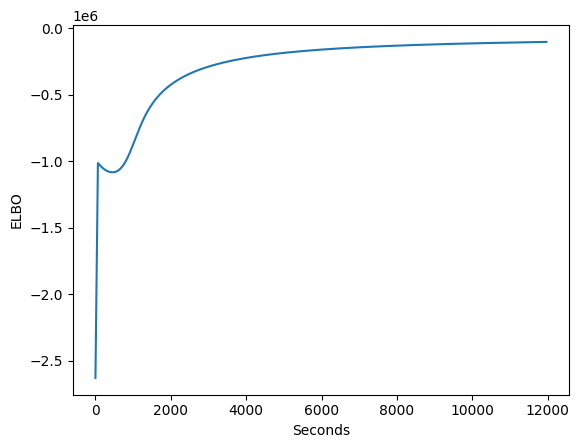

In [270]:
plt.xlabel("Seconds")
plt.ylabel("ELBO")
plt.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))

plt.plot(np.linspace(0, float(stop-start), len(ELBOs)), ELBOs)

In [272]:
word_topic_probs = LAMBDA / LAMBDA.sum(axis=1, keepdims=True)
top_words = {}
for k in range(word_topic_probs.shape[0]):
    top_idxs = np.argsort(word_topic_probs[k, :])[-7:][::-1]
    top_words[k] = [vocab[v] for v in top_idxs]

top_words

{0: ['party', 'court', 'percent', 'police', 'gorbachev', 'states', 'two'],
 1: ['percent', 'new', 'two', 'company', 'president', 'york', 'time'],
 2: ['soviet', 'state', 'million', 'first', 'new', 'department', 'government'],
 3: ['year', 'today', 'york', 'says', 'spokesman', 'monday', 'market'],
 4: ['new', 'time', 'united', 'million', 'soviet', 'world', 'told'],
 5: ['year', 'million', 'years', 'today', 'two', 'dukakis', 'house'],
 6: ['united', 'bush', 'president', 'states', 'soviet', 'reagan', 'national'],
 7: ['percent', 'new', 'people', 'million', 'year', 'two', 'government'],
 8: ['last', 'state', 'two', 'year', 'officials', 'government', 'first'],
 9: ['party', 'united', 'defense', 'case', 'expected', 'day', 'money'],
 10: ['cdy', 'clr', 'rn', 'company', 'million', 'first', 'two'],
 11: ['percent', 'time', 'bush', 'billion', 'friday', 'police', 'million'],
 12: ['people', 'officials', 'percent', 'years', 'today', 'back', 'american'],
 13: ['new', 'year', 'national', 'friday', '

In [374]:
with open("ap.txt", "r") as file:
    raw_text = file.read()
documents = re.findall(r"<TEXT>(.*?)</TEXT>", raw_text, re.DOTALL)
documents = [doc.strip().replace("\n", " ") for doc in documents]
stop_words = set(stopwords.words("english"))
word_counts = Counter()
tokenized_documents = []

for doc in documents:
    tokens = word_tokenize(doc.lower())
    filtered_tokens = [word for word in tokens if word.isalpha() and word \
                       not in stop_words]
    tokenized_documents.append(filtered_tokens)
    word_counts.update(filtered_tokens)

reduced_vocab = [word for word, _ in word_counts.most_common(1000)]
vocab_to_idx = {word: idx for idx, word in enumerate(reduced_vocab)}
reduced_corpus_matrix = []
for tokens in tokenized_documents:
    reduced_doc = [vocab_to_idx[word] for word in tokens if \
                   word in vocab_to_idx]
    if reduced_doc:
        reduced_corpus_matrix.append(reduced_doc)

In [432]:
def init_variational_params(corpus_mat, K, V):
    N = len(corpus_mat)
    LAMBDA = np.random.uniform(low=0.01, high=1.00, size=(K, V))
    GAMMA = np.ones((N, K))
    PHI = [np.ones((len(doc), K)) / K for doc in corpus_mat]

    return LAMBDA, GAMMA, PHI

def compute_ELBO(LAMBDA, GAMMA, PHI, corpus_mat):
    N = len(corpus_mat)
    ELBO = 0

    E_log_p_BETA = np.sum(
        (ETA-1) * (digamma(LAMBDA) - digamma(np.sum(LAMBDA, axis=1, keepdims=True)))
        )
    ELBO += E_log_p_BETA

    E_log_p_THETA = np.sum(
        (ALPHA-1) * (digamma(GAMMA) - digamma(np.sum(GAMMA, axis=1, keepdims=True)))
    )
    ELBO += E_log_p_THETA

    E_log_p_z_x = 0
    for i in range(N):
        M = len(corpus_mat[i])
        for j in range(M):
            x_ij = corpus_mat[i][j]
            E_log_p_z_x += np.sum(PHI[i][j] * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))) \
                + np.sum(PHI[i][j] * (digamma(LAMBDA[:, x_ij]) - digamma(np.sum(LAMBDA[:, x_ij]))))
    ELBO += E_log_p_z_x

    E_q_log_BETA = np.sum(
        -loggamma(np.sum(LAMBDA, axis=1)) + np.sum(loggamma(LAMBDA), axis=1) \
            - np.sum((LAMBDA - 1) * (digamma(LAMBDA) - digamma(np.sum(LAMBDA, axis=1, keepdims=True))), axis=1)
    )
    ELBO += E_q_log_BETA

    E_q_log_THETA = np.sum(
        -loggamma(np.sum(GAMMA, axis=1)) + np.sum(loggamma(GAMMA), axis=1) \
        - np.sum((GAMMA - 1) * (digamma(GAMMA) - digamma(np.sum(GAMMA, axis=1, keepdims=True))), axis=1)
    )
    ELBO += E_q_log_THETA

    E_log_q_z = 0
    for i, doc in enumerate(corpus_mat):
        for j, x_ij in enumerate(doc):  # x_ij is the word index
            PHI_nonzero = PHI[i][j][PHI[i][j] > 0]
            E_log_q_z += -np.sum(PHI[i][j] * np.log(PHI[i][j] + 1e-10))
    ELBO += E_log_q_z

    return ELBO

def update_variational_params(LAMBDA, GAMMA, PHI, corpus_mat, K, V):
    for i in tqdm(range(N), desc="Updating PHI and GAMMA"):
        M = len(corpus_mat[i])
        for j in range(M):
            x_ij = corpus_mat[i][j]
            exp_propto = digamma(LAMBDA[:, x_ij]) - digamma(np.sum(LAMBDA[:, x_ij])) \
                + digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))
            PHI[i][j] = np.exp(exp_propto - log_sum_exp(exp_propto))

        for k in range(K):
            GAMMA[i, k] = ALPHA + np.sum(PHI[i][:, k])

    LAMBDA = np.full((K, V), ETA)
    for i, doc in enumerate(tqdm(corpus_mat, desc="Updating LAMBDA")):
        doc_word_idxs = np.array(doc)
        for k in range(K):
            np.add.at(LAMBDA[k], doc_word_idxs, PHI[i][:, k])

    return LAMBDA, GAMMA, PHI

In [ ]:
K = 30
V = len(reduced_vocab)
ETA = 1 / V
ALPHA = 0.5

tol = 300
iteration = 1
max_iterations = 100
curr_ELBO = 0
prev_ELBO = 301
ELBOs = []

start = time.time()
LAMBDA, GAMMA, PHI = init_variational_params(corpus_mat=reduced_corpus_matrix, K=30, V=len(reduced_vocab))
ELBOs.append(compute_ELBO(LAMBDA=LAMBDA, GAMMA=GAMMA, PHI=PHI, corpus_mat=reduced_corpus_matrix))
print(f"Initial ELBO: {ELBOs[0]}\n")

while iteration <= max_iterations:
    LAMBDA, GAMMA, PHI = update_variational_params(LAMBDA=LAMBDA, GAMMA=GAMMA, PHI=PHI, corpus_mat=reduced_corpus_matrix, K=30, V=len(reduced_vocab))
    prev_ELBO = curr_ELBO
    curr_ELBO = compute_ELBO(LAMBDA=LAMBDA, GAMMA=GAMMA, PHI=PHI, corpus_mat=reduced_corpus_matrix)
    print(f"Current ELBO: {curr_ELBO}")
    ELBOs.append(curr_ELBO)

    if np.abs(curr_ELBO - prev_ELBO) <= tol:
        break

    iteration += 1
    print("\n")
stop = time.time()

Initial ELBO: -1998357.0717729595



Updating LAMBDA: 100%|██████████| 2244/2244 [00:00<00:00, 15865.23it/s]


Current ELBO: -955086.5964575101




Updating LAMBDA: 100%|██████████| 2244/2244 [00:00<00:00, 16655.37it/s]


Current ELBO: -936542.3090329937




Updating LAMBDA: 100%|██████████| 2244/2244 [00:00<00:00, 12495.73it/s]


Current ELBO: -920430.6357205363




Updating LAMBDA: 100%|██████████| 2244/2244 [00:00<00:00, 14980.68it/s]


Current ELBO: -898516.9147196409




Updating LAMBDA: 100%|██████████| 2244/2244 [00:00<00:00, 15295.14it/s]


Current ELBO: -854718.1272002291




Updating LAMBDA: 100%|██████████| 2244/2244 [00:00<00:00, 15338.89it/s]


Current ELBO: -763917.6120078405




Updating LAMBDA: 100%|██████████| 2244/2244 [00:00<00:00, 15194.69it/s]


Current ELBO: -620076.3103675582




Updating LAMBDA: 100%|██████████| 2244/2244 [00:00<00:00, 15093.16it/s]


Current ELBO: -467120.82421793137




Updating LAMBDA: 100%|██████████| 2244/2244 [00:00<00:00, 15330.94it/s]


Current ELBO: -348249.89343416755




Updating LAMBDA: 100%|██████████| 2244/2244 [00:00<00:00, 15309.65it/s]


Current ELBO: -268735.26962418813




Updating LAMBDA: 100%|██████████| 2244/2244 [00:00<00:00, 15869.92it/s]


Current ELBO: -214754.67370883308




Updating LAMBDA: 100%|██████████| 2244/2244 [00:00<00:00, 15229.63it/s]


Current ELBO: -176592.7910859641




Updating LAMBDA: 100%|██████████| 2244/2244 [00:00<00:00, 15084.89it/s]


Current ELBO: -151856.61472640344




Updating LAMBDA: 100%|██████████| 2244/2244 [00:00<00:00, 15121.04it/s]


Current ELBO: -138308.80396519313




Updating LAMBDA: 100%|██████████| 2244/2244 [00:00<00:00, 14906.92it/s]


Current ELBO: -131846.11366887175




Updating LAMBDA: 100%|██████████| 2244/2244 [00:00<00:00, 15225.29it/s]


Current ELBO: -128663.63026960137




Updating LAMBDA: 100%|██████████| 2244/2244 [00:00<00:00, 14791.07it/s]


Current ELBO: -127066.82369756233




Updating LAMBDA: 100%|██████████| 2244/2244 [00:00<00:00, 14793.21it/s]


Current ELBO: -126137.21846327742




Updating LAMBDA: 100%|██████████| 2244/2244 [00:00<00:00, 14958.47it/s]


Current ELBO: -125398.11181046435




Updating LAMBDA: 100%|██████████| 2244/2244 [00:00<00:00, 14896.82it/s]


Current ELBO: -124644.38240266021




Updating LAMBDA: 100%|██████████| 2244/2244 [00:00<00:00, 14785.01it/s]


Current ELBO: -123906.949060119




Updating LAMBDA: 100%|██████████| 2244/2244 [00:00<00:00, 14951.08it/s]


Current ELBO: -123213.93248013289




Updating LAMBDA: 100%|██████████| 2244/2244 [00:00<00:00, 14985.55it/s]


Current ELBO: -122628.65643577043




Updating LAMBDA: 100%|██████████| 2244/2244 [00:00<00:00, 15063.98it/s]


Current ELBO: -122155.90268914086




Updating LAMBDA: 100%|██████████| 2244/2244 [00:00<00:00, 15573.81it/s]


Current ELBO: -121784.89577075662




Updating LAMBDA: 100%|██████████| 2244/2244 [00:00<00:00, 14941.32it/s]


Current ELBO: -121454.08753798537




Updating LAMBDA: 100%|██████████| 2244/2244 [00:00<00:00, 12462.11it/s]


Current ELBO: -121158.37078628481


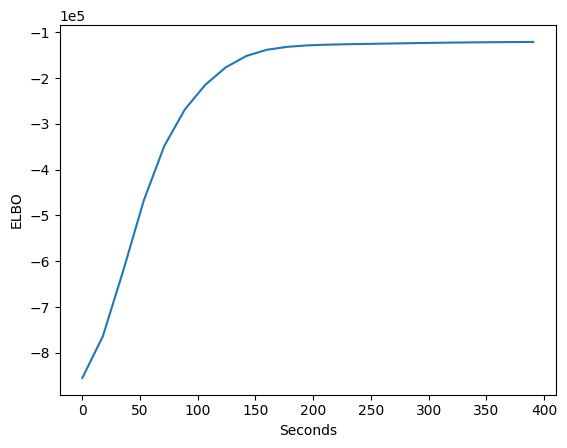

In [437]:
plt.xlabel("Seconds")
plt.ylabel("ELBO")
plt.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))

plt.plot(np.linspace(0, float(stop-start), len(ELBOs[5:])), ELBOs[5:])

In [431]:
word_topic_probs = LAMBDA / LAMBDA.sum(axis=1, keepdims=True)
top_words = {}
for k in range(word_topic_probs.shape[0]):
    top_idxs = np.argsort(word_topic_probs[k, :])[-7:][::-1]
    top_words[k] = [reduced_vocab[v] for v in top_idxs]

top_words

{0: ['said', 'northwest', 'lines', 'voted', 'consider', 'ban', 'makes'],
 1: ['said', 'northwest', 'lines', 'voted', 'consider', 'ban', 'makes'],
 2: ['said', 'northwest', 'lines', 'voted', 'consider', 'ban', 'makes'],
 3: ['said', 'northwest', 'lines', 'voted', 'consider', 'ban', 'makes'],
 4: ['said', 'northwest', 'lines', 'voted', 'consider', 'ban', 'makes'],
 5: ['said', 'northwest', 'lines', 'voted', 'consider', 'ban', 'makes'],
 6: ['dollar', 'yen', 'baker', 'mayor', 'bad', 'said', 'northwest'],
 7: ['said', 'northwest', 'lines', 'voted', 'consider', 'ban', 'makes'],
 8: ['time',
  'monday',
  'foreign',
  'take',
  'program',
  'international',
  'system'],
 9: ['said', 'northwest', 'lines', 'voted', 'consider', 'ban', 'makes'],
 10: ['said', 'northwest', 'lines', 'voted', 'consider', 'ban', 'makes'],
 11: ['judge', 'move', 'seven', 'town', 'base', 'nothing', 'october'],
 12: ['said', 'northwest', 'lines', 'voted', 'consider', 'ban', 'makes'],
 13: ['said', 'northwest', 'lines',